In [1]:
import os
import json
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

In [2]:
# Check if file is uploaded
if not os.path.exists('kaggle.json'):
    print("Please upload your kaggle.json file to the Files tab on the left!")
    from google.colab import files
    files.upload()

# Move kaggle.json to the hidden .kaggle folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API configured.")

Please upload your kaggle.json file to the Files tab on the left!


Saving kaggle.json to kaggle.json
Kaggle API configured.


In [3]:
import os
import zipfile

print("--- DOWNLOADING DATASET ---")
# Only download if not already there to save time
if not os.path.exists("5class-weather-status-image-classification.zip"):
    !kaggle datasets download -d ammaralfaifi/5class-weather-status-image-classification

print("Unzipping...")
with zipfile.ZipFile("5class-weather-status-image-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("weather_data")

# --- FIX: POINT DIRECTLY TO 'data' ---
base_dir = "weather_data/data"

if os.path.exists(base_dir):
    print(f" Dataset path set to: {base_dir}")
    print(f"Classes found: {os.listdir(base_dir)}")
else:
    print(" Still can't find it. Let's look deeper:")
    for root, dirs, files in os.walk("weather_data"):
        print(root, dirs)

--- DOWNLOADING DATASET ---
Dataset URL: https://www.kaggle.com/datasets/ammaralfaifi/5class-weather-status-image-classification
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 98% 490M/498M [00:02<00:00, 170MB/s]
100% 498M/498M [00:02<00:00, 196MB/s]
Unzipping...
 Dataset path set to: weather_data/data
Classes found: ['cloudy', 'rainy', 'snowy', 'foggy', 'sunny']


Class Distribution:
cloudy: 6702
rainy: 1927
snowy: 1875
foggy: 1261
sunny: 6274


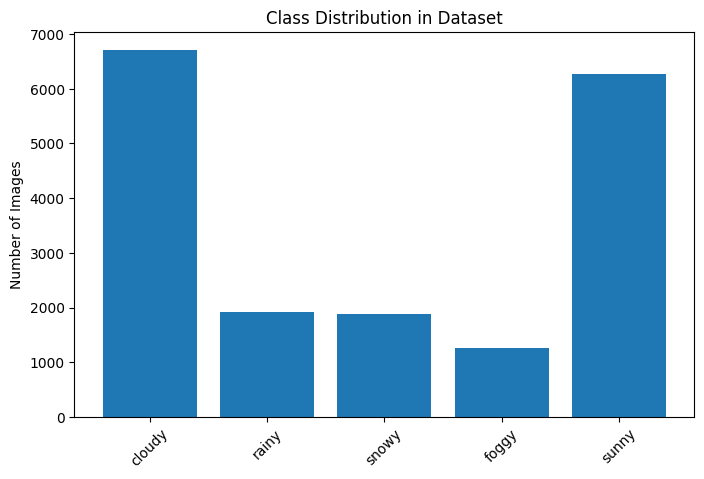

In [4]:
import matplotlib.pyplot as plt
from collections import Counter
import os

# Count samples per class
class_counts = Counter()

for root, dirs, files in os.walk(base_dir):
    for cls in dirs:
        cls_path = os.path.join(root, cls)
        class_counts[cls] = len(os.listdir(cls_path))

print("Class Distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# Bar plot
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Class Distribution in Dataset")
plt.ylabel("Number of Images")
plt.show()

In [9]:
import os
import tensorflow as tf

# 1. Setup Path (Same as before)
if os.path.exists("weather_data/data"):
    base_dir = "weather_data/data"
elif os.path.exists("weather_data/dataset"):
    base_dir = "weather_data/dataset"
else:
    for root, dirs, files in os.walk("weather_data"):
        if "Sunrise" in dirs:
            base_dir = root
            break

print(f"--- STARTING TENSORFLOW COMPATIBILITY SCAN: {base_dir} ---")
removed_count = 0

# 2. Strict Extension List (TensorFlow only supports these)
valid_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

for root, dirs, files in os.walk(base_dir):
    for file in files:
        file_path = os.path.join(root, file)
        ext = os.path.splitext(file)[1].lower()

        # Step A: Delete if extension is wrong (e.g., .tif, .txt, .db)
        if ext not in valid_exts:
            print(f"Removing invalid extension: {file_path}")
            os.remove(file_path)
            removed_count += 1
            continue

        # Step B: Try to decode with TensorFlow
        try:
            raw_file = tf.io.read_file(file_path)
            # This is the exact function causing your error
            img = tf.io.decode_image(raw_file, expand_animations=False)

            # Force execution to ensure it's readable
            # (Sometimes TF is lazy and won't error until you check shape)
            if img.shape is None:
                raise ValueError("Image has no shape")

        except Exception as e:
            print(f"❌ TF cannot decode: {file_path}")
            print(f"   Reason: {e}")
            os.remove(file_path)
            removed_count += 1

print(f"--- SCAN COMPLETE. Removed {removed_count} files. ---")

--- STARTING TENSORFLOW COMPATIBILITY SCAN: weather_data/data ---
❌ TF cannot decode: weather_data/data/rainy/70.jpg
   Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
❌ TF cannot decode: weather_data/data/rainy/62.jpg
   Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
❌ TF cannot decode: weather_data/data/rainy/64.jpg
   Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
❌ TF cannot decode: weather_data/data/rainy/35.jpg
   Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, 

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import shutil

# --- 1. DEFINE PATH ---
if os.path.exists("weather_data/data"):
    base_dir = "weather_data/data"
elif os.path.exists("weather_data/dataset"):
    base_dir = "weather_data/dataset"
else:
    base_dir = "weather_data" # Default fallback
    for root, dirs, files in os.walk("weather_data"):
        if "Sunrise" in dirs:
            base_dir = root
            break

print(f"--- LOADING IMAGES FROM: {base_dir} ---")

# --- 2. CLEANUP: REMOVE NON-IMAGE FILES ---
# This fixes the "Unknown image file format" error by removing hidden files
# like .ipynb_checkpoints which often appear in Colab/Jupyter.
allowed_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
files_deleted = 0

for root, dirs, files in os.walk(base_dir):
    # Remove hidden checkpoint directories
    if ".ipynb_checkpoints" in dirs:
        shutil.rmtree(os.path.join(root, ".ipynb_checkpoints"))
        dirs.remove(".ipynb_checkpoints") # prevent walking into it

    for file in files:
        file_path = os.path.join(root, file)
        ext = os.path.splitext(file)[1].lower()

        # Delete if extension is not valid
        if ext not in allowed_extensions:
            try:
                os.remove(file_path)
                files_deleted += 1
            except OSError as e:
                print(f"Error deleting {file_path}: {e}")

if files_deleted > 0:
    print(f"-> Cleanup: Removed {files_deleted} non-image files/checkpoints.")

# --- 3. DATA LOADING ---
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# --- 4. CALCULATE CLASS WEIGHTS ---
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract labels from training dataset
# Note: This iterates the dataset. If a bad file remains, it crashes here.
print("Extracting labels for class weighting...")
y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(labels.numpy())

y_train = np.array(y_train)

class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights_values))
print("Class Weights:", class_weights)

# --- 5. AUGMENTATION & PIPELINE ---
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes: {class_names}")

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(500).prefetch(buffer_size=1)
val_ds = val_ds.prefetch(buffer_size=1)

print("Data pipeline ready (Batch Size: 16)")

--- LOADING IMAGES FROM: weather_data/data ---
Found 17977 files belonging to 5 classes.
Using 14382 files for training.
Found 17977 files belonging to 5 classes.
Using 3595 files for validation.
Extracting labels for class weighting...
Class Weights: {0: np.float64(0.5381478016838166), 1: np.float64(2.8507433102081268), 2: np.float64(1.925301204819277), 3: np.float64(1.9163224516988675), 4: np.float64(0.5715080468905226)}
Classes: ['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']
Data pipeline ready (Batch Size: 16)


In [11]:
# CELL 5: Build Model
print("--- BUILDING MODEL (MobileNetV2) ---")

# 1. Load Pre-trained MobileNetV2 (without the top classification layer)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# 2. Freeze Base Layers
# We freeze them so we don't destroy the patterns it already knows
base_model.trainable = False

# 3. Add Custom Classification Head
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)

# MobileNet specific preprocessing (-1 to 1 scaling)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Flatten features
x = layers.Dropout(0.2)(x)             # Drop 20% to prevent overfitting
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.summary()


--- BUILDING MODEL (MobileNetV2) ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# CELL 6: Compile Configuration

# Learning Rate Schedule: Start at 0.001, decay by 10% every 1000 steps
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # We track accuracy as required

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_weather_model.keras', monitor='val_accuracy', save_best_only=True)
]
print(" Model compiled and ready to train.")

# CELL: Stronger Regularization to Fix Overfitting
from tensorflow.keras import regularizers

print("BUILDING ROBUST MODEL (High Regularization)")

# 1. Update Augmentation (Make it harder)
# We increased rotation and zoom from 0.1 to 0.2
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2), # Harder rotation
    layers.RandomZoom(0.2),     # Harder zoom
    layers.RandomContrast(0.2), # Harder contrast
])

# 2. Re-load MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# 3. Build the Head with "Anti-Overfitting" Tools
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

# CHANGE 1: Increase Dropout from 0.2 to 0.5
# This forces the model to rely on more features, not just one or two
x = layers.Dropout(0.5)(x)

# CHANGE 2: Add L2 Regularization
# This penalizes the model for being "too confident" (large weights)
outputs = layers.Dense(num_classes,
                       activation='softmax',
                       kernel_regularizer=regularizers.l2(0.01))(x)

model = models.Model(inputs, outputs)

# 4. Compile
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9
)

model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

 Model compiled and ready to train.
BUILDING ROBUST MODEL (High Regularization)


In [16]:
#CELL 7: Cleanup + Load + Train
import os
import gc
import tensorflow as tf
from tensorflow.keras import optimizers

# --- STEP 1: FORCE THE CORRECT PATH ---
# We know it's usually here based on your logs
base_dir = "weather_data/data"

# Fallback check: if 'data' doesn't exist, try 'dataset'
if not os.path.exists(base_dir):
    if os.path.exists("weather_data/dataset"):
        base_dir = "weather_data/dataset"
    else:
        # Last resort: find where 'rainy' folder is
        for root, dirs, files in os.walk("weather_data"):
            if "rainy" in dirs:
                base_dir = root
                break

print(f" TARGET FOLDER: {base_dir}")

# --- STEP 2: REMOVE BAD FILES ---
print("--- CLEANING CORRUPTED IMAGES ---")
removed = 0
for root, dirs, files in os.walk(base_dir):
    for file in files:
        path = os.path.join(root, file)
        try:
            # Delete if empty or unreadable
            if os.path.getsize(path) == 0:
                os.remove(path)
                removed += 1
            else:
                # Try to decode (if this fails, it's corrupt)
                img = tf.io.read_file(path)
                _ = tf.io.decode_image(img, expand_animations=False)
        except:
            print(f"Removing bad file: {file}")
            os.remove(path)
            removed += 1
print(f"✅ Cleanup done. Removed {removed} bad files.")

# --- STEP 3: RELOAD DATA
print("--- RELOADING DATA ---")
BATCH_SIZE = 16 # Safe for RAM
IMG_SIZE = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir, validation_split=0.2, subset="training",
    seed=123, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir, validation_split=0.2, subset="validation",
    seed=123, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

# Optimize for Low RAM
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(500).prefetch(buffer_size=1)
val_ds = val_ds.prefetch(buffer_size=1)

# --- STEP 4: RE-COMPILE & TRAIN ---
print("--- STARTING TRAINING ---")
gc.collect() # Clean RAM

# We must re-compile to ensure optimizer is attached correctly
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9
)
model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weights
)

 TARGET FOLDER: weather_data/data
--- CLEANING CORRUPTED IMAGES ---
✅ Cleanup done. Removed 0 bad files.
--- RELOADING DATA ---
Found 17977 files belonging to 5 classes.
Using 14382 files for training.
Found 17977 files belonging to 5 classes.
Using 3595 files for validation.
--- STARTING TRAINING ---
Epoch 1/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.4558 - loss: 1.4317 - val_accuracy: 0.5766 - val_loss: 1.1107
Epoch 2/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - accuracy: 0.6049 - loss: 0.9528 - val_accuracy: 0.6106 - val_loss: 1.0197
Epoch 3/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - accuracy: 0.6113 - loss: 0.9369 - val_accuracy: 0.6072 - val_loss: 1.0310
Epoch 4/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.6348 - loss: 0.8748 - val_accuracy: 0.5944 - val_loss: 1.0449
Epoch 5/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.6188 - loss: 0.8815 - val_accuracy: 0.6211 - val_loss: 0.9917
Epoch 6/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 45s 42m

In [17]:
# CELL 7.5: Fine-Tuning

print("--- STARTING FINE-TUNING ---")
# 1. Unfreeze the base model
base_model.trainable = True

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

print("Base model unfrozen. Training top layers...")

# 4. Train for 10 more epochs
fine_tune_epochs = 10
total_epochs = 15 + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1], # Start where we left off
                         validation_data=val_ds,
                         callbacks=callbacks)
print("Fine-tuning complete!")

--- STARTING FINE-TUNING ---
Base model unfrozen. Training top layers...
Epoch 15/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.5765 - loss: 1.1120 - val_accuracy: 0.6782 - val_loss: 0.7818
Epoch 16/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 66s 65ms/step - accuracy: 0.7005 - loss: 0.7838 - val_accuracy: 0.7547 - val_loss: 0.6474
Epoch 17/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 70s 68ms/step - accuracy: 0.7409 - loss: 0.7087 - val_accuracy: 0.8050 - val_loss: 0.5611
Epoch 18/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 66s 65ms/step - accuracy: 0.7698 - loss: 0.6379 - val_accuracy: 0.8134 - val_loss: 0.5470
Epoch 19/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 69s 68ms/step - accuracy: 0.7868 - loss: 0.6095 - val_accuracy: 0.8248 - val_loss: 0.5180
Epoch 20/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 66s 64ms/step - accuracy: 0.7859 - loss: 0.6018 - val_accuracy: 0.8295 - val_loss: 0.4970
Epoch 21/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 65s 63ms/step - accuracy: 0.8027 - loss: 0.5593 - val_accuracy: 0.8234 - val_loss: 0.5071
Epoch 22/2

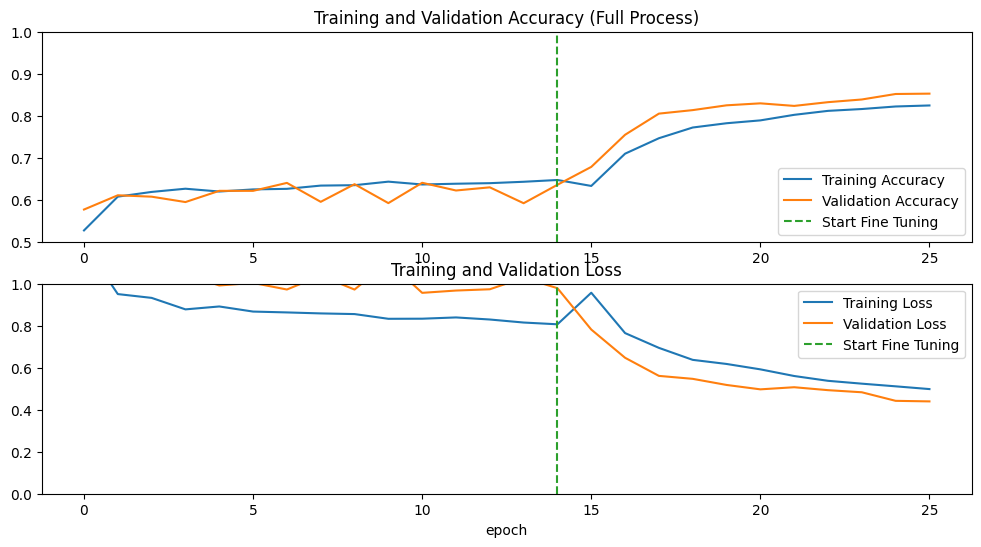

In [18]:
# CELL 8: Plot Full Training History
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([15-1,15-1], plt.ylim(), label='Start Fine Tuning', linestyle='--') # Vertical line at epoch 15
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Full Process)')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([15-1,15-1], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
# CELL 9: Classification Report & Metrics
from sklearn.metrics import classification_report
import numpy as np

print("--- GENERATING PREDICTIONS ---")
print("Extracting labels and predictions (this ensures they match perfectly)...")

# We iterate the dataset once to get images and labels aligned
y_true = []
y_pred_probs = []


for images, labels in val_ds:
    y_true.extend(labels.numpy())
    # Predict batch
    probs = model.predict(images, verbose=0)
    y_pred_probs.extend(probs)

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1) # Convert probabilities to class ID

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=class_names))

--- GENERATING PREDICTIONS ---
Extracting labels and predictions (this ensures they match perfectly)...

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

      cloudy       0.87      0.81      0.84      1357
       foggy       0.91      0.88      0.90       252
       rainy       0.84      0.82      0.83       371
       snowy       0.79      0.93      0.85       374
       sunny       0.85      0.88      0.87      1241

    accuracy                           0.85      3595
   macro avg       0.85      0.86      0.86      3595
weighted avg       0.85      0.85      0.85      3595



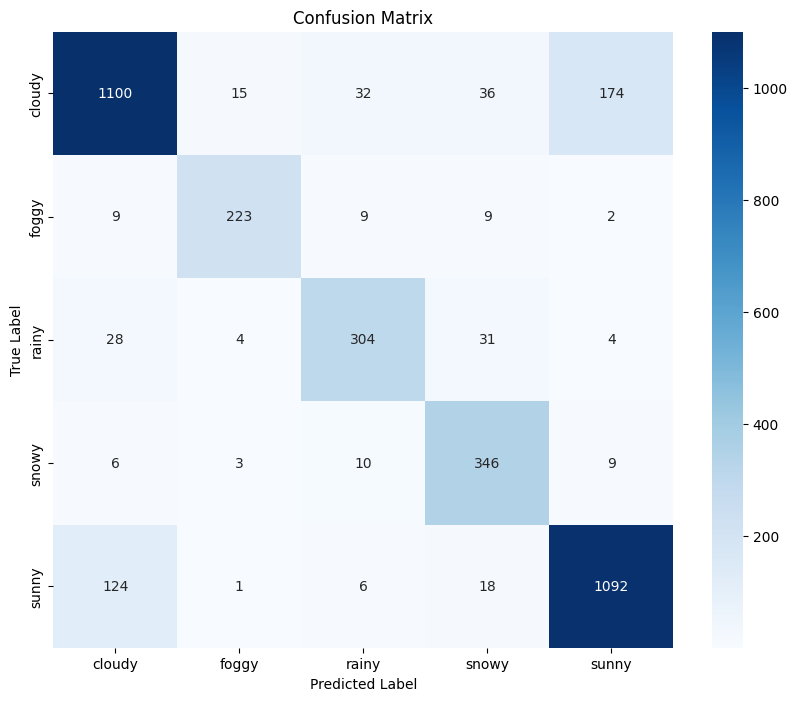

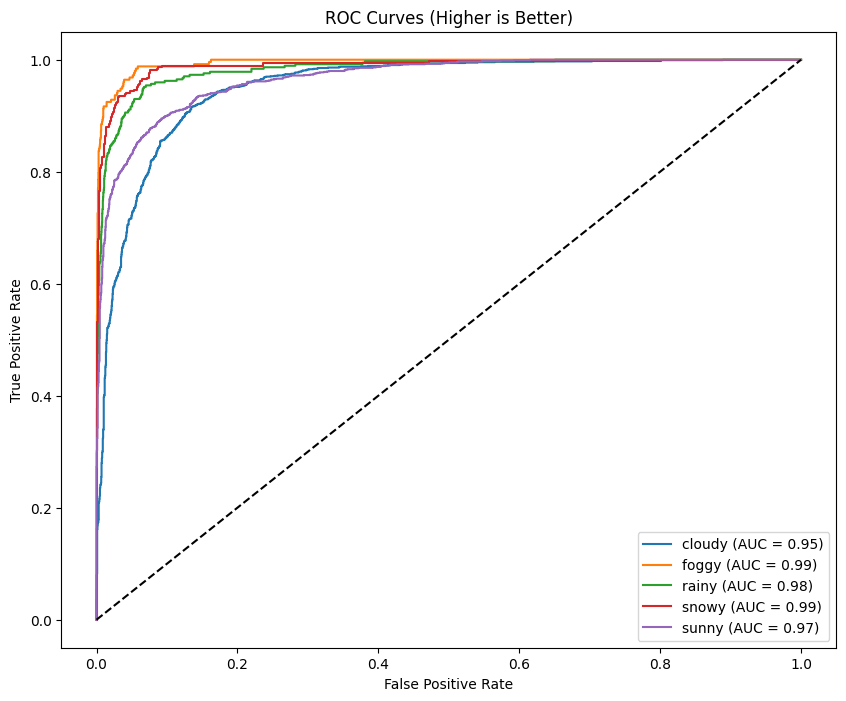

In [20]:
# CELL 10: Confusion Matrix & ROC
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

# 1. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. ROC Curves
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)
n_classes = len(class_names)

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Higher is Better)')
plt.legend(loc='lower right')
plt.show()

In [21]:
model.save('final_weather_mobilenet.keras')
print(" Model saved as 'final_weather_mobilenet.keras'")
print("Go to the Files tab on the left to download it!")

 Model saved as 'final_weather_mobilenet.keras'
Go to the Files tab on the left to download it!
